# 1.0 Model Creation and Training

In [1]:
#installing necessary libraries

!pip install yfinance
!pip install findspark
!pip install pyspark
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=d56e2b27cc2ade007284ffb24aa2eddf63f7a93683c5fd2054bb1b1ba5fa0e50
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
Looking in indexes: https://pypi.org/simple, https://

In [5]:

import pandas as pd
import csv
import datetime
import yfinance as yf
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup as bs
import requests
from pyspark.sql.functions import sum,max,min,mean,count
import datetime as dt
import pyspark
from pyspark.sql import SparkSession
import findspark
import yaml
from yaml.loader import SafeLoader
from os.path import abspath
!git clone https://github.com/Pansyhb/BigData.git

fatal: destination path 'BigData' already exists and is not an empty directory.


## 1.1 Read in CSV Files Containing Data for Target Companies

In [9]:
from os import listdir
import pandas as pd
path = '/content/BigData/Final_project_files/data/'

from sklearn.preprocessing import MinMaxScaler
#Function to read in csv files and scale columns for data where scaling of predictions is eventually needed
def scale(path):
    scaler_list = []
    target_list = []
    feat_list = []
    for item in listdir(path):
        print(str(item))
        df = pd.read_csv(path + str(item))
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        print(df)
        #create scaler instances
        scaler = MinMaxScaler(feature_range=(0,1))
        target_scaler = MinMaxScaler(feature_range = (0,1))
        data = df.drop(['ticker'],axis=1)
        # scale features and target columns
        target = target_scaler.fit_transform(data[['target']])
        target = target.flatten()
        scaler_list.append(target_scaler)
        target_list.append(target)
        X_feat = data.drop(['target'], axis = 1)
        for col in X_feat.columns:
            X_feat[col] = scaler.fit_transform(X_feat[[col]])
        feat_list.append(X_feat)
    return scaler_list, target_list, feat_list
scaler_list, target_list, feat_list = scale(path) 

GOOG_dataframe.csv
           ticker       open       high        low      close  adj_close  \
date                                                                       
2016-01-04   GOOG  37.150002  37.202999  36.562901  37.091999  37.091999   
2016-01-05   GOOG  37.322498  37.599998  36.931999  37.129002  37.129002   
2016-01-06   GOOG  36.500000  37.359001  36.445999  37.181000  37.181000   
2016-01-07   GOOG  36.515499  36.924999  35.952999  36.319500  36.319500   
2016-01-08   GOOG  36.572498  36.661499  35.650002  35.723499  35.723499   
...           ...        ...        ...        ...        ...        ...   
2023-02-23   GOOG  92.129997  92.129997  90.010002  91.070000  91.070000   
2023-02-24   GOOG  89.629997  90.129997  88.860001  89.349998  89.349998   
2023-02-27   GOOG  90.089996  90.449997  89.610001  90.099998  90.099998   
2023-02-28   GOOG  89.540001  91.449997  89.519997  90.300003  90.300003   
2023-03-01   GOOG  90.160004  91.199997  89.849998  90.510002  90.510

In [10]:
#Split training and test data (microsoft and google) was well as features and targets
test_data = feat_list[0]   
test_target = target_list[0]
train_data = feat_list[1] 
train_target = target_list[1]
print(train_data.reset_index().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1802 non-null   datetime64[ns]
 1   open        1802 non-null   float64       
 2   high        1802 non-null   float64       
 3   low         1802 non-null   float64       
 4   close       1802 non-null   float64       
 5   adj_close   1802 non-null   float64       
 6   volume      1802 non-null   float64       
 7   tenmda      1802 non-null   float64       
 8   twentymda   1802 non-null   float64       
 9   fiftymda    1802 non-null   float64       
 10  hundredmda  1802 non-null   float64       
 11  EWMA_20     1802 non-null   float64       
 12  EWMA_50     1802 non-null   float64       
 13  EWMA_100    1802 non-null   float64       
 14  rsi         1802 non-null   float64       
 15  MiddleBand  1802 non-null   float64       
 16  UpperBand   1802 non-nul

In [11]:
# Split data into X_train and y_train data sets
import numpy as np
def lstm_split(data,target,steps):
      X = []
      y = []
      # Creating a data structure with 10 time-steps and 1 output
      for i in range(10, steps):
          X.append(data[i-10:i])
          y.append(target[i])  
      return np.array(X),np.array(y)
 
X1,y1 = lstm_split(train_data, train_target,len(train_data))

#Define Training and Test Datasets
def train_split(x1, y1, train_data):
  train_split = 0.9
  split_idx = int(np.ceil(len(X1)*train_split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_split(X1, y1, train_data)
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1792, 10, 18) (1613, 10, 18) (179, 10, 18) (179,) (1613,)


#2.0 Setup the models LSTM & Prophet models for a single stock 

##2.1 Configure the base LSTM model 
This process involved running a random search function to select best hyperparameters for the network. The results of this search are availble below.


In [43]:
!pip install tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner

#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['accuracy'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective = 'val_loss', max_trials = 50, seed = 1)

#complete training 
tune.search(X_train, y_train, epochs = 200, batch_size = 20, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
LSTM_model.save('main_models/LSTM_model1.h5')
hyperparameters = tune.get_best_hyperparameters()[0]
print(hyperparameters.values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
{'n_hidden': 0, 'neurons_visible': 58, 'activate1': 'sigmoid', 'dropout1': 0.7, 'neurons_hidden1': 50, 'dropout2': 0.4, 'neurons_hidden2': 20, 'dropout3': 0.7, 'neurons_hidden3': 40}


In [45]:
history= LSTM_model.fit(X_train, y_train, epochs=50, batch_size= 10)

Epoch 1/50
162/162 [==============================] - 3s 17ms/step - loss: 0.0014 - accuracy: 0.0012
Epoch 2/50
162/162 [==============================] - 2s 14ms/step - loss: 0.0015 - accuracy: 0.0012
Epoch 3/50
162/162 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.0012
Epoch 4/50
162/162 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.0012
Epoch 5/50
162/162 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.0012
Epoch 6/50
162/162 [==============================] - 1s 6ms/step - loss: 0.0015 - accuracy: 0.0012
Epoch 7/50
162/162 [==============================] - 1s 7ms/step - loss: 0.0015 - accuracy: 0.0012
Epoch 8/50
162/162 [==============================] - 1s 7ms/step - loss: 0.0017 - accuracy: 0.0012
Epoch 9/50
162/162 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.0012
Epoch 10/50
162/162 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.00

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

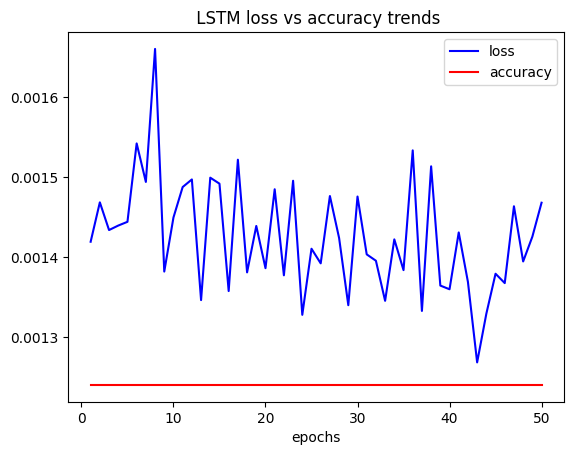

In [54]:
import matplotlib.pyplot as plt
x=np.arange(1,51, 1)
plt.plot(x,history.history['loss'], "b", label= "loss")
plt.plot(x,history.history['accuracy'], "r", label= "accuracy")

plt.title(" LSTM loss vs accuracy trends")
plt.xlabel('epochs')
plt.legend()
plt.show()

In [19]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  m_pred = model.predict(trainset)
  return m_pred

In [20]:
X_test.shape

(179, 10, 18)

In [21]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('main_models/LSTM_model1.h5', X_test)
LSTM_MSFT_test.shape

6/6 [==============================] - 0s 4ms/step


(179, 1)

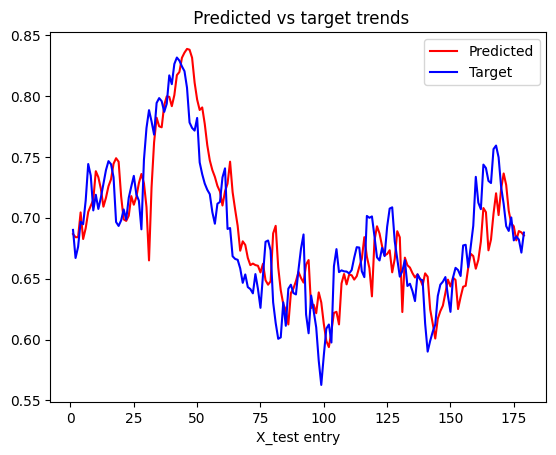

In [67]:
import matplotlib.pyplot as plt
x=np.arange(1,180, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

## 2.2 Configure the Prophet Model

In [14]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
!pip install yfinance
import yfinance as yf
import datetime as dt

#Generate basic financial data from yfinance for prophet training
def prophet_data(ticker, start_day, month, year):
    delta = dt.timedelta(days = 150)
    data = yf.download(ticker, (dt.date(year, month, start_day) - delta)).reset_index()
    print(data.head())
    data = data.rename(columns = {'Date':'ds', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Adj Close': 'y', 'Volume':'volume'})
    print(data.head())
    data = data.loc[:,['ds', 'y']]
    return data

MSFT_data = prophet_data('MSFT',1, 1,2016)
GOOG_data = prophet_data('GOOG', 1, 1, 2016)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
        Date       Open       High        Low      Close  Adj Close    Volume
0 2015-08-04  46.750000  47.709999  46.680000  47.540001  41.953972  33403900
1 2015-08-05  47.980000  48.410000  47.540001  47.580002  41.989281  26959700
2 2015-08-06  47.709999  47.770000  46.330002  46.619999  41.142078  27368000
3 2015-08-07  46.389999  46.779999  46.259998  46.740002  41.247974  19163000
4 2015-08-10  46.950001  47.490002  46.840000  47.330002  41.768654  23079900
          ds       open       high        low      close          y    volume
0 2015-08-04  46.750000  47.709999  46.680000  47.540001  41.953972  33403900
1 2015-08-05  47.980000  48.410000  47.540001  47.580002  41.989281  26959700
2 2015-08-06  47.709999  47.770000  46.330002  46.619999  41.142078  27368000
3 2015-08-07  46.389999  46.779999  46.259998  46.74

In [15]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(MSFT_data)

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/2uxt_m84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/3i4gq8za.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39804', 'data', 'file=/tmp/tmpyueia72l/2uxt_m84.json', 'init=/tmp/tmpyueia72l/3i4gq8za.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modeln7exj76a/prophet_model-20230408030150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:01:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/5mcekvsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/4v92jqdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26802', 'data', 'file=/tmp/tmpyueia72l/5mcekvsf.json', 'init=/tmp/tmpyueia72l/4v92jqdi.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model2w4u84c8/prophet_model-20230408030153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:01:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:01:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/bkjt6zhe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/2vj6in3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/mrfwipp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99369', 'data', 'file=/tmp/tmpyueia72l/mj0t_3bc.json', 'init=/tmp/tmpyueia72l/mrfwipp3.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelmpo5rtbk/prophet_model-20230408030348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/v45i1l9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/pn_yth70.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38517', 'data', 'file=/tmp/tmpyueia72l/v45i1l9c.json', 'init=/tmp/tmpyueia72l/pn_yth70.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modeln1_2x8bj/prophet_model-20230408030350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:03:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/g_wg0kxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/8p3kt_0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:05:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/x8qmfy6q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/o875wcb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30378', 'data', 'file=/tmp/tmpyueia72l/x8qmfy6q.json', 'init=/tmp/tmpyueia72l/o875wcb3.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model03rnoxnx/prophet_model-20230408030532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:05:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/fbb4z_v3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/akr6flr1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/2ex2ircs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93507', 'data', 'file=/tmp/tmpyueia72l/aldwd2yg.json', 'init=/tmp/tmpyueia72l/2ex2ircs.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model31957jh2/prophet_model-20230408030714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:07:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/w36psnez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/3h5scl9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3214', 'data', 'file=/tmp/tmpyueia72l/w36psnez.json', 'init=/tmp/tmpyueia72l/3h5scl9o.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelxpil8kuo/prophet_model-20230408030716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/reufn3z4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/em5vrbl8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


03:09:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/n8e99ote.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/61eiem75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34400', 'data', 'file=/tmp/tmpyueia72l/n8e99ote.json', 'init=/tmp/tmpyueia72l/61eiem75.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model9g3omk6i/prophet_model-20230408030905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:09:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:09:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/zgci0r57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/1qvscgc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


03:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/8st0nbxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/prshr7_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89164', 'data', 'file=/tmp/tmpyueia72l/8st0nbxu.json', 'init=/tmp/tmpyueia72l/prshr7_4.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelqj0ecrvz/prophet_model-20230408031111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:11:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:11:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/gqhqx7pj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/md_9l8u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


03:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/ln1jxtcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/8fux4l81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16385', 'data', 'file=/tmp/tmpyueia72l/ln1jxtcm.json', 'init=/tmp/tmpyueia72l/8fux4l81.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelrjlgu6rm/prophet_model-20230408031421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/hz20_707.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/bfl9xjw0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


03:18:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/ffei8a73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/qhz08mo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45508', 'data', 'file=/tmp/tmpyueia72l/ffei8a73.json', 'init=/tmp/tmpyueia72l/qhz08mo7.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelmzsh2qb9/prophet_model-20230408031823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/l5dwuoxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/x5vvx2r0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9904', 'data', 'file=/tmp/tmpyueia72l/ajg2a0pz.json', 'init=/tmp/tmpyueia72l/mddiw7fj.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelbi_mymi_/prophet_model-20230408032226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:22:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/qazzp4lo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/zjs6e8ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5834', 'data', 'file=/tmp/tmpyueia72l/qazzp4lo.json', 'init=/tmp/tmpyueia72l/zjs6e8ws.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelff9bx3q5/prophet_model-20230408032228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:22:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/7o2h5lvu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/roh690r9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


03:26:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/gtd1nw4r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/losk50pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96839', 'data', 'file=/tmp/tmpyueia72l/gtd1nw4r.json', 'init=/tmp/tmpyueia72l/losk50pi.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelurczwq44/prophet_model-20230408032629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:26:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/jebgmt0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/6thyhmfw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


03:30:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/3y6ij7zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/utxncap7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81372', 'data', 'file=/tmp/tmpyueia72l/3y6ij7zv.json', 'init=/tmp/tmpyueia72l/utxncap7.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelz3pi6jv4/prophet_model-20230408033044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:30:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/wzd2wpn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/r8uev1b0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


03:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/klu9joz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/qjqx_97l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80597', 'data', 'file=/tmp/tmpyueia72l/klu9joz1.json', 'init=/tmp/tmpyueia72l/qjqx_97l.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelt3q2uyad/prophet_model-20230408033508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:35:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/rfm3pjqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/ce0p52kq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12730', 'data', 'file=/tmp/tmpyueia72l/70y5u8wz.json', 'init=/tmp/tmpyueia72l/6h83jarz.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model76a09ppu/prophet_model-20230408034219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:42:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:42:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/39s_td3b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/w6ff67b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48207', 'data', 'file=/tmp/tmpyueia72l/39s_td3b.json', 'init=/tmp/tmpyueia72l/w6ff67b4.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelvq49mu21/prophet_model-20230408034221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/4mj2o82m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/2wv913w6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/zf00u8nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99579', 'data', 'file=/tmp/tmpyueia72l/tu1a_h1_.json', 'init=/tmp/tmpyueia72l/zf00u8nz.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelza6e3z8j/prophet_model-20230408034727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:47:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:47:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/1xv6pwz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/h9byl7cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8056', 'data', 'file=/tmp/tmpyueia72l/1xv6pwz9.json', 'init=/tmp/tmpyueia72l/h9byl7cf.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelh6reca_x/prophet_model-20230408034730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:47:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/38kvkw5l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/dh85yp43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:52:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/ih2shnh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/d8lja83i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83563', 'data', 'file=/tmp/tmpyueia72l/ih2shnh4.json', 'init=/tmp/tmpyueia72l/d8lja83i.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelyn0fywl_/prophet_model-20230408035226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:52:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:52:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/fb_ggmvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/4desdbuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


03:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/9aqh6mj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/wf0fap9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76600', 'data', 'file=/tmp/tmpyueia72l/9aqh6mj6.json', 'init=/tmp/tmpyueia72l/wf0fap9p.json', 'output', 'file=/tmp/tmpyueia72l/prophet_model1e7ty3w5/prophet_model-20230408035728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/fgv_q4vq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/wx9mr03h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


04:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/2jstr0e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/oom6fd_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78265', 'data', 'file=/tmp/tmpyueia72l/2jstr0e4.json', 'init=/tmp/tmpyueia72l/oom6fd_8.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelhuq920tv/prophet_model-20230408040224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:02:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/sg631eap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/b1d_pk4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Testing parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


INFO:cmdstanpy:Chain [1] start processing
04:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 180 forecasts with cutoffs between 2018-05-02 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/180 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/w07cixwj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/f2l1miqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91075', 'data', 'file=/tmp/tmpyueia72l/w07cixwj.json', 'init=/tmp/tmpyueia72l/f2l1miqs.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelgwnogstg/prophet_model-20230408040731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/dvz0_lub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/jrxqdtvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Best parameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
Minimum cross-validation error: 405.4231722858519


In [64]:
df_metrics
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-03,89.493668,88.150963,90.783348,88.780884,2018-05-02
1,2018-05-04,89.921755,88.702185,91.122591,89.809601,2018-05-02
2,2018-05-07,90.784139,89.486027,92.027546,90.810005,2018-05-02
3,2018-05-08,91.163165,89.888069,92.439879,90.423042,2018-05-02
4,2018-05-09,91.596249,90.296984,92.918714,91.489525,2018-05-02
...,...,...,...,...,...,...
1236,2023-03-31,238.620260,228.972893,248.399676,288.299988,2023-03-27
1237,2023-04-03,236.956333,227.668579,246.492625,287.230011,2023-03-27
1238,2023-04-04,236.056644,226.661955,245.717448,287.179993,2023-03-27
1239,2023-04-05,236.087217,226.868069,245.391388,284.339996,2023-03-27


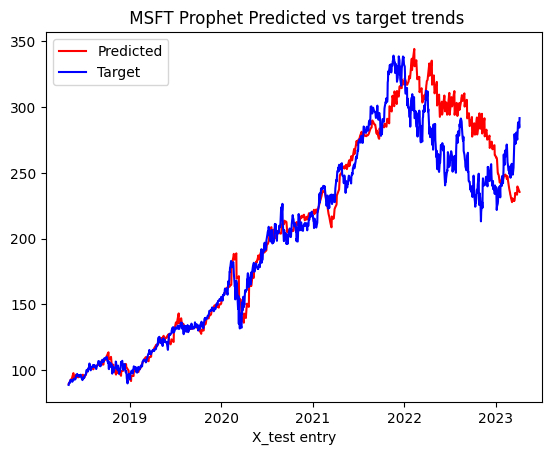

In [66]:
#ploting MSFT Prophet predictions
import matplotlib.pyplot as plt
x=df_cv['ds']
plt.plot(x,df_cv['yhat'], "r", label= "Predicted")
plt.plot(x,df_cv['y'], "b", label= "Target")

plt.title(" MSFT Prophet Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

### 2.2.1 Generate predictions on test data

In [16]:
# We use the best parameter to fit the model
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(df)
  df = cross_validation(model=final_model, initial='100 days', horizon='10 days', period='10 days')
  return df

#generate msft and google prediction datasets 
GOOG_data = get_data(GOOG_data)[['ds', 'yhat']]
MSFT_data = get_data(MSFT_data)[['ds', 'yhat']]


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/pntk92qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/cc912axl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10089', 'data', 'file=/tmp/tmpyueia72l/pntk92qn.json', 'init=/tmp/tmpyueia72l/cc912axl.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelvdt08yo1/prophet_model-20230408041253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 270 forecasts with cutoffs between 2015-11-14 00:00:00 and 2023-03-27 00:00:00


  0%|          | 0/270 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/yerg_baz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/oo62khik.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45314', 'data', 'file=/tmp/tmpyueia72l/yerg_baz.json', 'init=/tmp/tmpyueia72l/oo62khik.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modeley1a9l4n/prophet_model-20230408041257.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/lj65bl2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/0scu7yl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/270 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/judeq0qi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/aws5w5rj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33934', 'data', 'file=/tmp/tmpyueia72l/judeq0qi.json', 'init=/tmp/tmpyueia72l/aws5w5rj.json', 'output', 'file=/tmp/tmpyueia72l/prophet_modelx1xiqgo8/prophet_model-20230408041725.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:17:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:17:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/shcwvye8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyueia72l/aj8qkzeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [59]:
def prep_prophet(prophet_pred, data1):
  print(prophet_pred.info())
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  scale = MinMaxScaler()
  main_data['yhat'] = scale.fit_transform(main_data[['yhat']])
  returned = main_data.loc['2016-01-01':'2023-03-01', 'yhat']
  return returned

Goog_data_proph = prep_prophet(GOOG_data, test_data)[10:]
Msft_train_proph= prep_prophet(MSFT_data, train_data)[10:1623]
Msft_test_proph = prep_prophet(MSFT_data, train_data)[1623:]
print(train_data.loc['2016-01-01':'2023-03-01',].shape)
print(Msft_train_proph)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1860 non-null   datetime64[ns]
 1   yhat    1860 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1860 non-null   datetime64[ns]
 1   yhat    1860 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.2 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1860 non-null   datetime64[ns]
 1   yhat    1860 non-null   float64       
dtypes: datetime64[ns](1

## 2.3 Create Dataset to train hybrid model

In [18]:
from keras.saving.legacy.save import load_model

#create training data using predictions from lstm and prophet
lstm = load_model('main_models/LSTM_model1.h5')
def return_hybrid_data(lstm_model, prophet_data, LSTM_data, LSTM_target):
  preds_dict = {}
  preds_dict['lstm_pred'] = lstm_model.predict(LSTM_data).flatten()
  print(lstm_model.predict(LSTM_data).shape)
  preds_dict['prophet_pred'] = prophet_data
  hybrid_train = pd.DataFrame(preds_dict)
  hybrid_train, target = lstm_split(hybrid_train, LSTM_target, len(hybrid_train))
  return hybrid_train, target

hybrid_train, target = return_hybrid_data(lstm, Msft_train_proph, X_train, y_train)

51/51 [==============================] - 0s 3ms/step
(1613, 1)


###2.3.1 Configure Hybrid Model

In [70]:
LR = 0.01
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 58, activation = "sigmoid", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["accuracy"])
    Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 50, batch_size = 20, callbacks = [Early_stop])
    return hybrid
    
#train the hybrid model
hybrid1 = multiple_models(hybrid_train, y_train[10:])
hybrid1.save('main_models/hybrid1.h5')

Epoch 1/50
81/81 [==============================] - 2s 7ms/step - loss: 0.1298 - accuracy: 0.0012
Epoch 2/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0273 - accuracy: 0.0012
Epoch 3/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0174 - accuracy: 0.0012
Epoch 4/50
81/81 [==============================] - 1s 11ms/step - loss: 0.0136 - accuracy: 0.0012
Epoch 5/50
81/81 [==============================] - 1s 16ms/step - loss: 0.0128 - accuracy: 0.0012
Epoch 6/50
81/81 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.0012
Epoch 7/50
81/81 [==============================] - 1s 15ms/step - loss: 0.0119 - accuracy: 0.0012
Epoch 8/50
81/81 [==============================] - 2s 19ms/step - loss: 0.0108 - accuracy: 0.0012
Epoch 9/50
81/81 [==============================] - 1s 16ms/step - loss: 0.0118 - accuracy: 0.0012
Epoch 10/50
81/81 [==============================] - 1s 18ms/step - loss: 0.0105 - accuracy: 0.0012
Epoch 11/5

In [80]:
hybrid1_history = hybrid1.fit(hybrid_train, y_train[10:],epochs = 50, batch_size = 20, callbacks = [Early_stop])
hybrid1_history.history??

Epoch 1/50
81/81 [==============================] - 1s 8ms/step - loss: 0.0105 - accuracy: 0.0012
Epoch 2/50
81/81 [==============================] - 1s 8ms/step - loss: 0.0111 - accuracy: 0.0012
Epoch 3/50
81/81 [==============================] - 1s 7ms/step - loss: 0.0091 - accuracy: 0.0012
Epoch 4/50
81/81 [==============================] - 1s 8ms/step - loss: 0.0092 - accuracy: 0.0012
Epoch 5/50
81/81 [==============================] - 1s 7ms/step - loss: 0.0096 - accuracy: 0.0012
Epoch 6/50
81/81 [==============================] - 1s 8ms/step - loss: 0.0088 - accuracy: 0.0012
Epoch 7/50
81/81 [==============================] - 1s 8ms/step - loss: 0.0096 - accuracy: 0.0012
Epoch 8/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 0.0012
Epoch 9/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0092 - accuracy: 0.0012
Epoch 10/50
81/81 [==============================] - 1s 12ms/step - loss: 0.0091 - accuracy: 0.0012
Epoch 11/50
81/8

In [84]:
hybrid1_history.history??

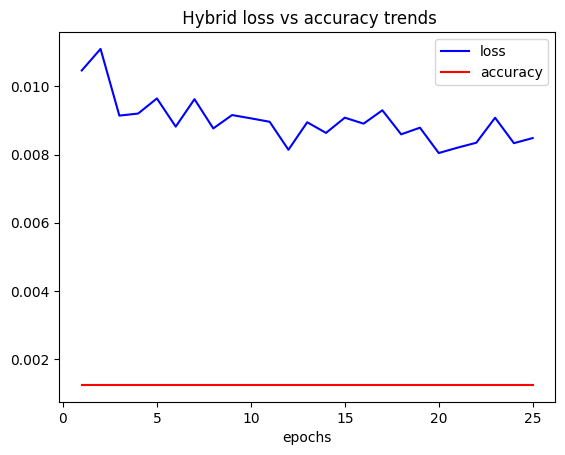

In [85]:
import matplotlib.pyplot as plt
x=np.arange(1,26, 1)
plt.plot(x,hybrid1_history.history['loss'], "b", label= "loss")
plt.plot(x,hybrid1_history.history['accuracy'], "r", label= "accuracy")

plt.title(" Hybrid loss vs accuracy trends")
plt.xlabel('epochs')
plt.legend()
plt.show()

##2.4 Test Single Company Models (LSTM vs. Hybrid)

In [ ]:
#Configure LSTM test using google data and micosoft validation data
goog_test, goog_target = lstm_split(test_data, test_target, len(test_data))
LSTM_predictions = lstm.predict(goog_test)
LSTM_validation = lstm.predict(X_test).flatten()
abs = scaler_list[1].inverse_transform([LSTM_validation]) - scaler_list[1].inverse_transform([y_test])

#Generate google test data for hybrid model

google_ft, google_target = return_hybrid_data(lstm, Goog_data_proph, goog_test, goog_target)
hybrid_val_feat, hybrid_val_target = return_hybrid_data(lstm, Msft_test_proph, X_test, y_test)


6/6 [==============================] - 0s 6ms/step
date
2016-01-19    0.015490
2016-01-20    0.016484
2016-01-21    0.016243
2016-01-22    0.015613
2016-01-25    0.017906
                ...   
2023-02-23    0.477089
2023-02-24    0.474497
2023-02-27    0.467847
2023-02-28    0.465430
2023-03-01    0.464413
Name: yhat, Length: 1792, dtype: float64
56/56 [==============================] - 0s 6ms/step
(1792, 1)
6/6 [==============================] - 0s 4ms/step
(179, 1)
[[ -2.19529961   1.41095637   3.26455313  -1.04150997  -4.08593878
   -3.34428401  -4.07592958  -0.83550844   2.21331312   3.86498477
    6.76880104   5.27610947  -4.19189363  -6.81205875  -7.76970372
   -3.6742091    1.98328643   3.80637403   4.56625121   3.19804319
   -1.1931655    0.7456853   -2.03441845  -1.40989063  -1.79656211
    6.28524615   6.84558613   4.63830286  -5.89369582  -7.03098123
   -7.2369991   -0.25206648   2.16650818  -2.12102996  -3.50785222
   -1.4537286    2.19401272   3.34518034  -1.50743354  -1.

###2.4.1 Microsoft Predictions on LSTM vs Hybrid

###2.4.2 Google Predicitions on Microsoft Model ( LSTM vs Hybrid)

In [86]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [87]:
mse, mae = compute_metrics(y1, predictions)
print(mae)

NameError: ignored

In [ ]:
plt.plot(y1, label="actual")
plt.plot(predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()

#3.0 Expanded Model

In [ ]:
LR = 0.01
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 58, activation = "sigmoid", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1))
    hybrid.compile(loss = 'mean_absolute_error', optimizer = Adam(lr = LR), metrics = ["mean_squared_error"])
    Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid.fit(x_train, y_train, epochs = 200, batch_size = 20, callbacks = [Early_stop])
    return hybrid
    
def create_data_lists(list_of_feats, list_of_targets):
  training_list = []
  target_list = []
  for data, target in zip(list_of_feats, list_of_targets):
    data_x, data_y = lstm_split(data, target, len(data))
    print(data_x.shape)
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#Train each of the lstm models on training companies
path = '/content/Git-6300/expanded_data/expanded_data/'
ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_scalers, targets, frames = scale(path)
training_list, target_list = create_data_lists(frames, targets)

for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.save('sub_models/'+tick+'_lstm.h5')

NFLX_dataframe.csv
           ticker        open        high         low       close   adj_close  \
date                                                                            
2016-01-04   NFLX  109.000000  110.000000  105.209999  109.959999  109.959999   
2016-01-05   NFLX  110.449997  110.580002  105.849998  107.660004  107.660004   
2016-01-06   NFLX  105.290001  117.910004  104.959999  117.680000  117.680000   
2016-01-07   NFLX  116.360001  122.180000  112.290001  114.559998  114.559998   
2016-01-08   NFLX  116.330002  117.720001  111.099998  111.389999  111.389999   
...           ...         ...         ...         ...         ...         ...   
2023-02-23   NFLX  331.230011  331.279999  314.299988  323.649994  323.649994   
2023-02-24   NFLX  319.299988  321.500000  314.519989  317.149994  317.149994   
2023-02-27   NFLX  323.869995  330.000000  322.119995  323.029999  323.029999   
2023-02-28   NFLX  323.700012  327.619995  321.170013  322.130005  322.130005   
2023-03-0

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


90/90 [==============================] - 2s 7ms/step - loss: 0.2320 - mean_squared_error: 0.1225
Epoch 2/200
90/90 [==============================] - 1s 9ms/step - loss: 0.1039 - mean_squared_error: 0.0182
Epoch 3/200
90/90 [==============================] - 1s 13ms/step - loss: 0.0823 - mean_squared_error: 0.0115
Epoch 4/200
90/90 [==============================] - 1s 11ms/step - loss: 0.0799 - mean_squared_error: 0.0109
Epoch 5/200
90/90 [==============================] - 1s 9ms/step - loss: 0.0743 - mean_squared_error: 0.0099
Epoch 6/200
90/90 [==============================] - 1s 7ms/step - loss: 0.0737 - mean_squared_error: 0.0095
Epoch 7/200
90/90 [==============================] - 1s 7ms/step - loss: 0.0702 - mean_squared_error: 0.0090
Epoch 8/200
90/90 [==============================] - 1s 7ms/step - loss: 0.0686 - mean_squared_error: 0.0082
Epoch 9/200
90/90 [==============================] - 1s 7ms/step - loss: 0.0689 - mean_squared_error: 0.0084
Epoch 10/200
90/90 [=========

## 3.1 Train Expanded Hybrid Model Using Predictions of all Sub-Models

In [ ]:
#Create Train Data for Hybrid Model Using Microsoft Predictions
from keras.saving.legacy.save import load_model
import os
def hybrid_trainer(direct, ticker_list, hybrid_train):
    preds_dict = {}
    path = direct
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        print(prediction.shape)
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    return preds_df

#generate training data for expanded hybrid model
hybrid_training_data =  hybrid_trainer('sub_models/', ticker_list, X_train) 
hybrid_training_data['prophet'] = np.array(Msft_train_proph)
hybrid_training_data, y_train = lstm_split(hybrid_training_data, target_list[0], len(hybrid_training_data))


In [ ]:
#Create and train the expanded hybrid model
hybrid_expanded = multiple_models(hybrid_training_data, y_train)
hybrid_expanded.save('main_models/hybrid_expanded.h5')

## 3.2 Test the Expanded Hybrid Model on Microsoft and Goole Test Data


In [ ]:
#Configure hybrid model testing data based on predictions from each of the four underlying models and prophet
from os import listdir
google_test = {}
microsoft_test = {}
path = 'sub_models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(path+model)
  print(goog_target)
  goog_preds = model.predict(goog_test).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

#set Prophet data
google_test['prophet'] = Goog_data_proph
microsoft_test['prophet'] = Msft_test_proph

#Create final test data for hybrid model
google_test = lstm_split(goog_test, goog_target, len(google_test))
microsoft_test = lstm_split(microsoft_test, y_test, len(microsoft_test))


[0.00800869 0.0069567  0.01309896 ... 0.68206193 0.67137238 0.68779697]
6/6 [==============================] - 0s 3ms/step
[0.00800869 0.0069567  0.01309896 ... 0.68206193 0.67137238 0.68779697]
6/6 [==============================] - 0s 3ms/step
[0.00800869 0.0069567  0.01309896 ... 0.68206193 0.67137238 0.68779697]
6/6 [==============================] - 0s 4ms/step
[0.00800869 0.0069567  0.01309896 ... 0.68206193 0.67137238 0.68779697]
6/6 [==============================] - 0s 4ms/step


In [ ]:
#Predict google and microsoft test data using the trained hybrid model
hybrid_expanded = load_model('main_models/hybrid_expanded.h5')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot MAE and loss
#plt.figure(figsize=(10, 6))
plt.plot(hybrid_history.history['mae'], label='MAE')
plt.plot(hybrid_history.history['loss'], label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

mse, mae = compute_metrics(y1, predictions)
print(mae)
plt.plot(y1, label="actual")
plt.plot(predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show()